In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

sns.set(style="whitegrid")

file_path = "C:/Users/Marcia Lopez/Desktop/pruebas/Base Airbnb NY.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.info())

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room  149.0               1                  9  20

In [4]:
filas_antes = df.shape[0]

df = df.drop_duplicates()

filas_despues = df.shape[0]

print(f"Filas duplicadas eliminadas. Total de filas antes: {filas_antes}, después: {filas_despues}. Filas eliminadas: {filas_antes - filas_despues}")

Filas duplicadas eliminadas. Total de filas antes: 48905, después: 48895. Filas eliminadas: 10


In [5]:
columnas_a_eliminar = ['id', 'host_id', 'host_name']
df = df.drop(columns=columnas_a_eliminar, errors='ignore')

In [6]:
df.fillna(df.mean(numeric_only=True), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\Marcia Lopez\AppData\Local\Temp\ipykernel_4392\2758422161.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [7]:
df = df[df['price'] < 5000]

In [8]:
df['neighbourhood_group'] = df['neighbourhood_group'].astype('category').cat.codes
df['room_type'] = df['room_type'].astype('category').cat.codes

In [9]:
df['offer_group'] = df.groupby('neighbourhood_group')['neighbourhood_group'].transform('count')

print("Columna 'offer_group' creada.")
print(df[['neighbourhood_group', 'offer_group']].head())

Columna 'offer_group' creada.
   neighbourhood_group  offer_group
0                    1        20097
1                    2        21644
2                    2        21644
3                    1        20097
4                    2        21644


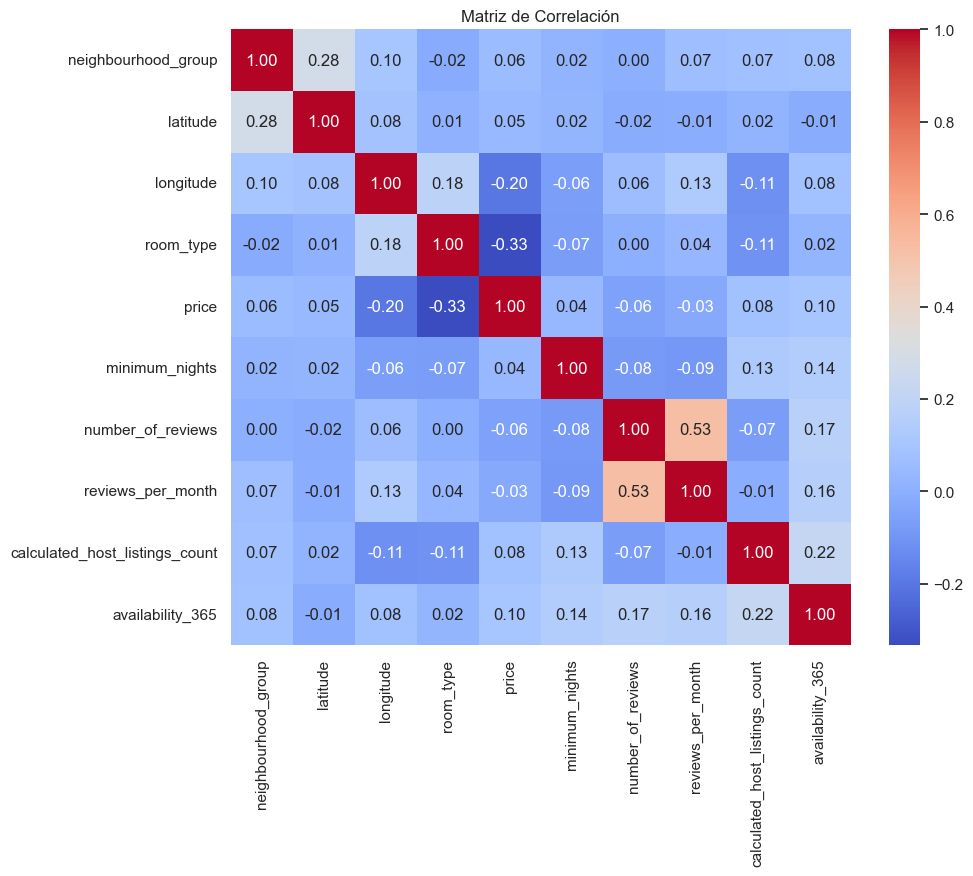

In [10]:
#Inciso #2 en el que se realiza la matríz de correlación con variables para considerar las convenientes en el modelo
variables = ['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

plt.figure(figsize=(10, 8))
sns.heatmap(df[variables].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

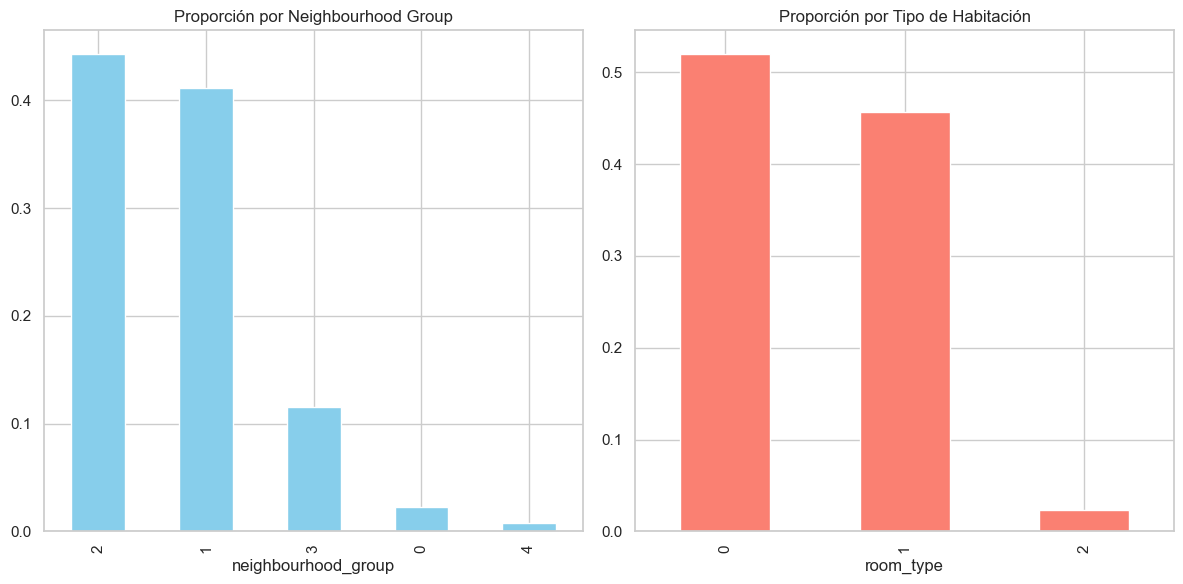

In [11]:
#Posteriormente realizo las proporciones para obtener las ofertas y tipos de habitación
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df['neighbourhood_group'].value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='skyblue', title='Proporción por Neighbourhood Group')
df['room_type'].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='salmon', title='Proporción por Tipo de Habitación')
plt.tight_layout()
plt.show()

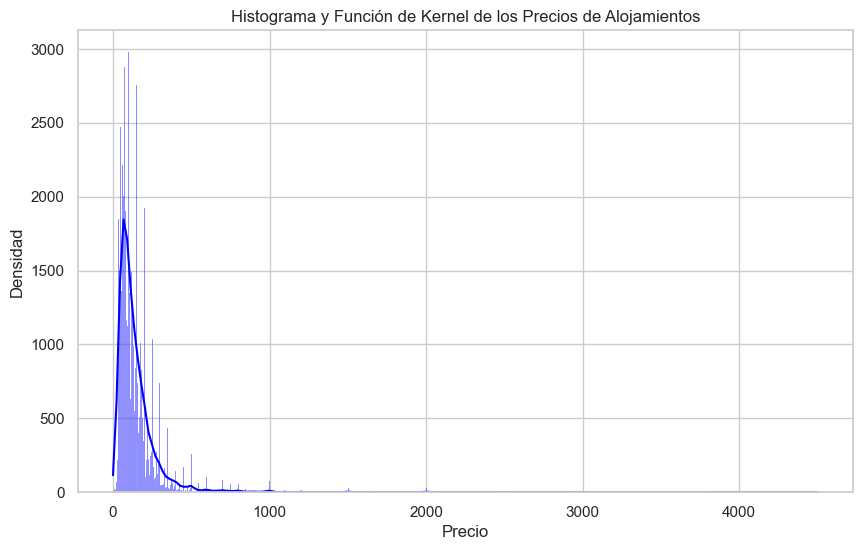

In [12]:
# Histograma y KDE de los precios
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, color='blue')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.title('Histograma y Función de Kernel de los Precios de Alojamientos')
plt.show()

In [35]:
import pandas as pd

precio_min = df['price'].min()
precio_max = df['price'].max()
precio_promedio = df['price'].mean()

print(f"Precio mínimo: {precio_min}, Precio máximo: {precio_max}, Precio promedio: {precio_promedio}")

media_por_grupo = df.groupby('neighbourhood_group')['price'].mean()
media_por_tipo = df.groupby('room_type')['price'].mean()

print("Media por Neighbourhood Group:")
print(media_por_grupo)

print("Media por Tipo de Habitación:")
print(media_por_tipo)

Precio mínimo: 0.0, Precio máximo: 4500.0, Precio promedio: 149.0427261065096
Media por Neighbourhood Group:
neighbourhood_group
0     87.584294
1    122.105992
2    191.376036
3     97.808025
4    101.680108
Name: price, dtype: float64
Media por Tipo de Habitación:
room_type
0    206.241242
1     88.086032
2     70.127586
Name: price, dtype: float64


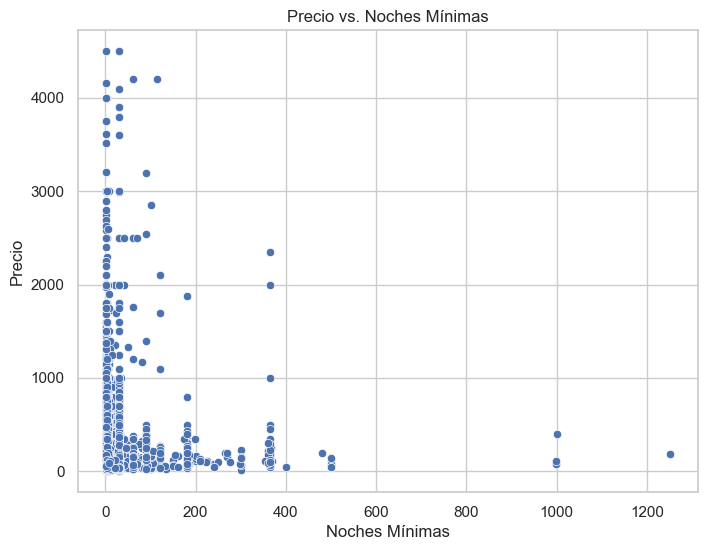

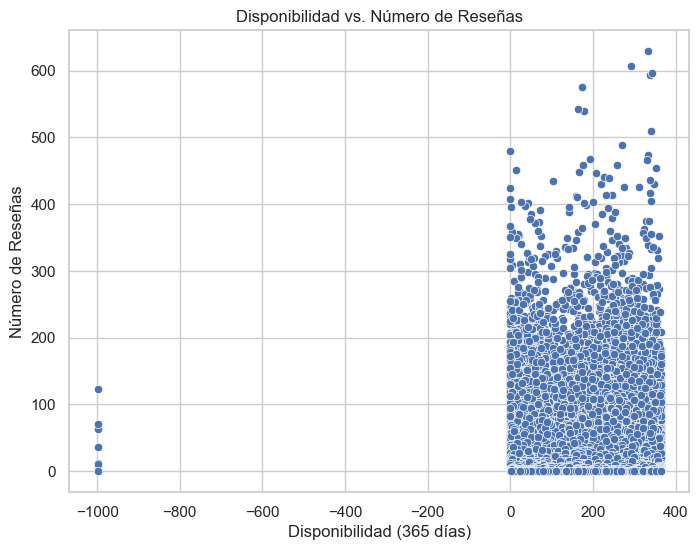

In [13]:
# Scatter para el cuarto inciso con variables de interés, como por ejemplo: price vs. minimum_nights
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='minimum_nights', y='price')
plt.title('Precio vs. Noches Mínimas')
plt.xlabel('Noches Mínimas')
plt.ylabel('Precio')
plt.show()

# Scatter plot 2: availability_365 vs. number_of_reviews
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='availability_365', y='number_of_reviews')
plt.title('Disponibilidad vs. Número de Reseñas')
plt.xlabel('Disponibilidad (365 días)')
plt.ylabel('Número de Reseñas')
plt.show()

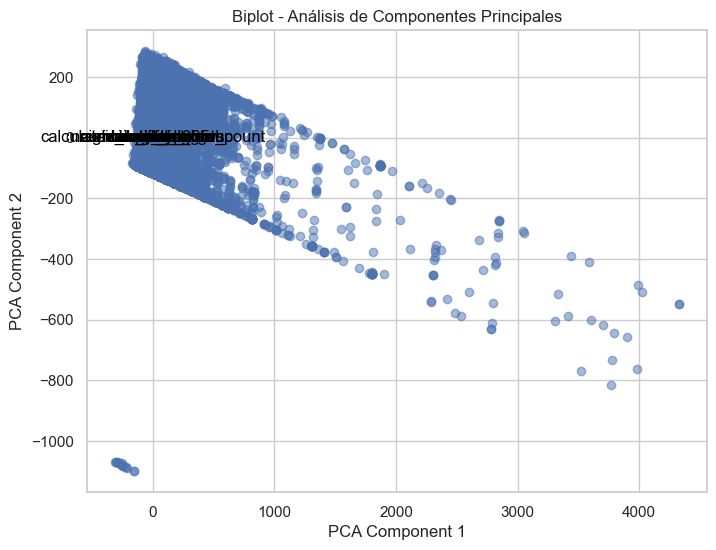

In [14]:
# Variables numéricas para poder lograr PCA 
pca_vars = df[variables].dropna()

# Aplicar PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_vars)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
for i, feature in enumerate(variables):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='red', alpha=0.5)
    plt.text(pca.components_[0, i] * 1.2, pca.components_[1, i] * 1.2, feature, color='black', ha='center', va='center')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Biplot - Análisis de Componentes Principales')
plt.show()

Varianza explicada por las dos primeras componentes: 93.49%


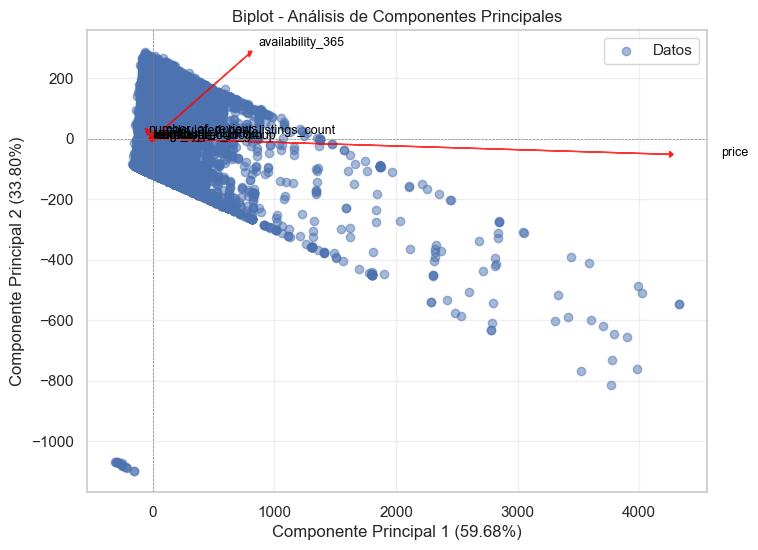

In [36]:
pca_vars = df[variables].dropna()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_vars)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Varianza explicada por las dos primeras componentes: {explained_variance_ratio.sum() * 100:.2f}%")

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, label='Datos')

for i, feature in enumerate(variables):
    plt.arrow(0, 0, 
              pca.components_[0, i] * max(pca_result[:, 0]), 
              pca.components_[1, i] * max(pca_result[:, 1]), 
              color='red', alpha=0.8, head_width=20)
    plt.text(pca.components_[0, i] * max(pca_result[:, 0]) * 1.1, 
             pca.components_[1, i] * max(pca_result[:, 1]) * 1.1, 
             feature, color='black', fontsize=9)

plt.xlabel(f'Componente Principal 1 ({explained_variance_ratio[0] * 100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({explained_variance_ratio[1] * 100:.2f}%)')
plt.title('Biplot - Análisis de Componentes Principales')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [15]:
# Definir las variables a eliminar para predecir price como modelo
columnas_a_eliminar = [
    'minimum_nights', 
    'number_of_reviews', 
    'reviews_per_month', 
    'calculated_host_listings_count', 
    'availability_365'
]

# Definir X y y para el modelo
y = df['price']  
X = df.drop(columns=['price'] + columnas_a_eliminar, errors='ignore') 

print("Variables eliminadas que pueden estar relacionadas con 'price':", columnas_a_eliminar)
print("Variables restantes para el modelo:\n", X.columns)

Variables eliminadas que pueden estar relacionadas con 'price': ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Variables restantes para el modelo:
 Index(['name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'last_review', 'offer_group'],
      dtype='object')


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

In [17]:
print(X.shape)  
print(y.shape)  
print(X.head())  
print(y.head())  

(48869, 8)
(48869,)
                                               name  neighbourhood_group  \
0                Clean & quiet apt home by the park                    1   
1                             Skylit Midtown Castle                    2   
2               THE VILLAGE OF HARLEM....NEW YORK !                    2   
3                   Cozy Entire Floor of Brownstone                    1   
4  Entire Apt: Spacious Studio/Loft by central park                    2   

  neighbourhood  latitude  longitude  room_type last_review  offer_group  
0    Kensington  40.64749  -73.97237          1  2018-10-19        20097  
1       Midtown  40.75362  -73.98377          0  2019-05-21        21644  
2        Harlem  40.80902  -73.94190          1  2019-06-23        21644  
3  Clinton Hill  40.68514  -73.95976          0  2019-07-05        20097  
4   East Harlem  40.79851  -73.94399          0  2018-11-19        21644  
0    149.0
1    225.0
2    150.0
3     89.0
4     80.0
Name: price, dtype

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)  
print(y_train.shape)

(34208, 8)
(34208,)


In [19]:
print(X.isnull().sum())  
print(y.isnull().sum())  

X = X.dropna()  
y = y.dropna()

name                   0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
last_review            0
offer_group            0
dtype: int64
0


In [20]:
y_train = y_train[X_train.index]

In [21]:
if X_train.empty or y_train.empty:
    raise ValueError("X_train o y_train están vacíos. Revisa los pasos previos.")

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

if isinstance(X, np.ndarray):
    X = pd.DataFrame(X)
if isinstance(y, np.ndarray):
    y = pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=["object", "category"]).columns

for col in categorical_columns:
    top_categories = X_train[col].value_counts().nlargest(10).index  
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), other="Other")
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), other="Other")

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, sparse=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True, sparse=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

selector = VarianceThreshold(threshold=0.01)  
X_train_reduced = selector.fit_transform(X_train)
X_test_reduced = selector.transform(X_test)

sample_size = 100
X_train_sample = X_train_reduced[:sample_size, :]
y_train_sample = y_train.iloc[:sample_size]

X_train_const = sm.add_constant(X_train_sample)
model = sm.OLS(y_train_sample, X_train_const).fit()

X_test_const = sm.add_constant(X_test_reduced)  
y_train_pred = model.predict(sm.add_constant(X_train_sample))  
y_test_pred = model.predict(X_test_const)  

mse_train = mean_squared_error(y_train_sample, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_sample, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'MSE': [mse_train, mse_test],
    'RMSE': [rmse_train, rmse_test],
    'MAE': [mae_train, mae_test],
}, index=['Entrenamiento', 'Prueba'])

print(results)

r2_train = r2_score(y_train_sample, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 (Entrenamiento): {r2_train}")
print(f"R^2 (Prueba): {r2_test}")

                        MSE        RMSE        MAE
Entrenamiento   6609.124925   81.296525  46.191939
Prueba         24051.026693  155.083934  72.111775
R^2 (Entrenamiento): 0.46430606631724225
R^2 (Prueba): 0.08908461653668309


C:\Users\Marcia Lopez\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Marcia Lopez\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Marcia Lopez\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [28]:
print(f"Mean price: {y.mean()}, Std of price: {y.std()}")

Mean price: 149.0427261065096, Std of price: 173.8547748072767
